# ZetaOrganism: Inteligencia Emergente Multi-Agente

Este notebook explora el sistema **ZetaOrganism**, donde la inteligencia colectiva emerge de interacciones simples entre celulas.

## Conceptos Clave

- **Emergencia**: Propiedades complejas que surgen de reglas simples
- **Dinamica Fi-Mi**: Lideres (Force) y seguidores (Mass)
- **Campo de Fuerza Zeta**: Atraccion con decaimiento basado en zeros de Riemann

## Contenido
1. Arquitectura del sistema
2. Estados celulares y dinamica Fi-Mi
3. Campo de fuerza con kernel zeta
4. Simulacion interactiva
5. Propiedades emergentes demostradas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import torch
from dataclasses import dataclass
from enum import Enum
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Configuracion visual
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Colores
COLORS = {
    'force': '#FF6B6B',      # Rojo - Lideres
    'mass': '#4ECDC4',       # Turquesa - Seguidores
    'corrupt': '#95A5A6',    # Gris - Corrompidos
    'field': '#FFD700',      # Dorado - Campo
    'energy': '#98FB98',     # Verde - Energia
    'food': '#FFA500',       # Naranja - Comida
}

## 1. Arquitectura del Sistema

```
ZetaOrganism
    |-- cells: List[OrganismCell]     # Agentes individuales
    |-- force_field: ForceField       # Campo de atraccion global
    |-- behavior_engine: BehaviorEngine  # Red neuronal para decisiones
    |-- grid: np.ndarray              # Espacio 2D discreto
```

Cada celula tiene:
- **Posicion** (x, y) en el grid
- **Estado**: FORCE, MASS, o CORRUPT
- **Energia**: 0.0 a 1.0
- **Memoria**: Historia de estados recientes

In [2]:
class CellState(Enum):
    """Estados posibles de una celula."""
    MASS = 0      # Seguidor - responde al gradiente
    FORCE = 1     # Lider - emite campo de atraccion
    CORRUPT = 2   # Danado - no participa en dinamica

@dataclass
class Cell:
    """Celula simplificada para demostracion."""
    x: float
    y: float
    state: CellState
    energy: float = 1.0
    
    def __post_init__(self):
        self.history: List[Tuple[float, float]] = [(self.x, self.y)]
    
    @property
    def color(self) -> str:
        return {
            CellState.FORCE: COLORS['force'],
            CellState.MASS: COLORS['mass'],
            CellState.CORRUPT: COLORS['corrupt']
        }[self.state]
    
    @property
    def size(self) -> float:
        base = 150 if self.state == CellState.FORCE else 80
        return base * self.energy

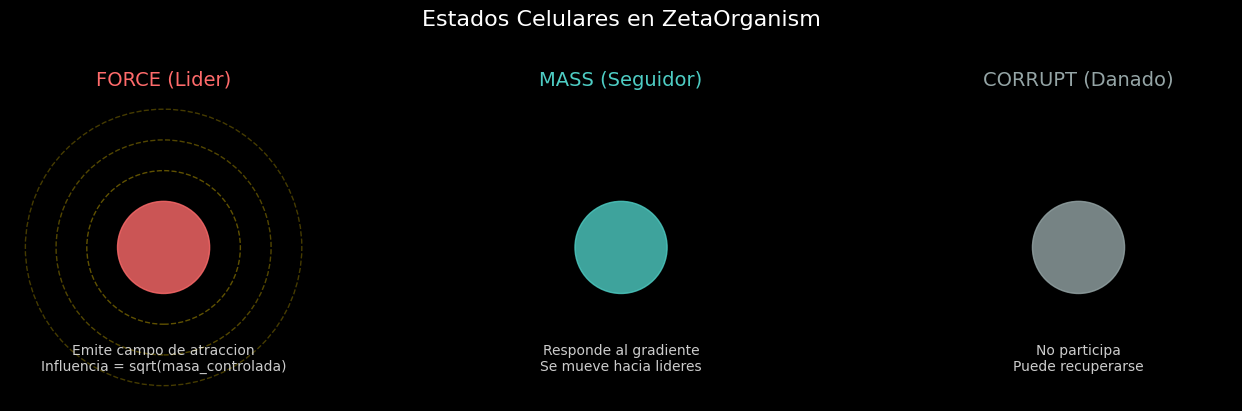

In [3]:
# Visualizar los tres estados
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

states_info = [
    (CellState.FORCE, 'FORCE (Lider)', 'Emite campo de atraccion\nInfluencia = sqrt(masa_controlada)'),
    (CellState.MASS, 'MASS (Seguidor)', 'Responde al gradiente\nSe mueve hacia lideres'),
    (CellState.CORRUPT, 'CORRUPT (Danado)', 'No participa\nPuede recuperarse')
]

for ax, (state, title, desc) in zip(axes, states_info):
    cell = Cell(0.5, 0.5, state)
    
    # Dibujar celula
    circle = Circle((0.5, 0.5), 0.15, color=cell.color, alpha=0.8)
    ax.add_patch(circle)
    
    # Si es FORCE, dibujar campo
    if state == CellState.FORCE:
        for r in [0.25, 0.35, 0.45]:
            field_circle = Circle((0.5, 0.5), r, fill=False, 
                                   color=COLORS['field'], alpha=0.5-r/2, linestyle='--')
            ax.add_patch(field_circle)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, color=cell.color)
    ax.text(0.5, 0.1, desc, ha='center', fontsize=10, alpha=0.8)
    ax.axis('off')

plt.suptitle('Estados Celulares en ZetaOrganism', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 2. Dinamica Fi-Mi (Force-Mass)

La interaccion fundamental es entre **lideres** (Fi) y **seguidores** (Mi):

### Ecuaciones

**Fuerza efectiva de un lider:**
$$F_i^{eff} = f(\sqrt{M_i^{controlled}})$$

**Movimiento de un seguidor hacia lider j:**
$$\vec{v}_i = \eta \cdot \nabla \Phi_j(\vec{r}_i)$$

Donde $\Phi_j$ es el campo de potencial del lider j.

In [4]:
# Zeros de Riemann para el kernel
ZETA_ZEROS = np.array([
    14.134725, 21.022040, 25.010858, 30.424876, 32.935062,
    37.586178, 40.918720, 43.327073, 48.005151, 49.773832,
    52.970321, 56.446248, 59.347044, 60.831779, 65.112544
])

def zeta_potential(r: np.ndarray, sigma: float = 0.1, M: int = 10) -> np.ndarray:
    """
    Potencial de atraccion basado en kernel zeta.
    
    Args:
        r: Distancia(s) al lider
        sigma: Parametro de regularizacion
        M: Numero de zeros a usar
    
    Returns:
        Potencial (mayor = mas atraccion)
    """
    r = np.atleast_1d(r)
    gammas = ZETA_ZEROS[:M]
    
    # Normalizar distancia
    r_norm = r / 10.0  # Escala tipica del grid
    
    potential = np.zeros_like(r, dtype=float)
    for gamma in gammas:
        weight = np.exp(-sigma * gamma)
        potential += weight * np.cos(gamma * r_norm)
    
    # Decaimiento con distancia
    potential *= np.exp(-r_norm * 2)
    
    return potential

def zeta_force(r: np.ndarray, sigma: float = 0.1, M: int = 10) -> np.ndarray:
    """
    Fuerza de atraccion (gradiente negativo del potencial).
    """
    dr = 0.01
    return -(zeta_potential(r + dr, sigma, M) - zeta_potential(r - dr, sigma, M)) / (2 * dr)

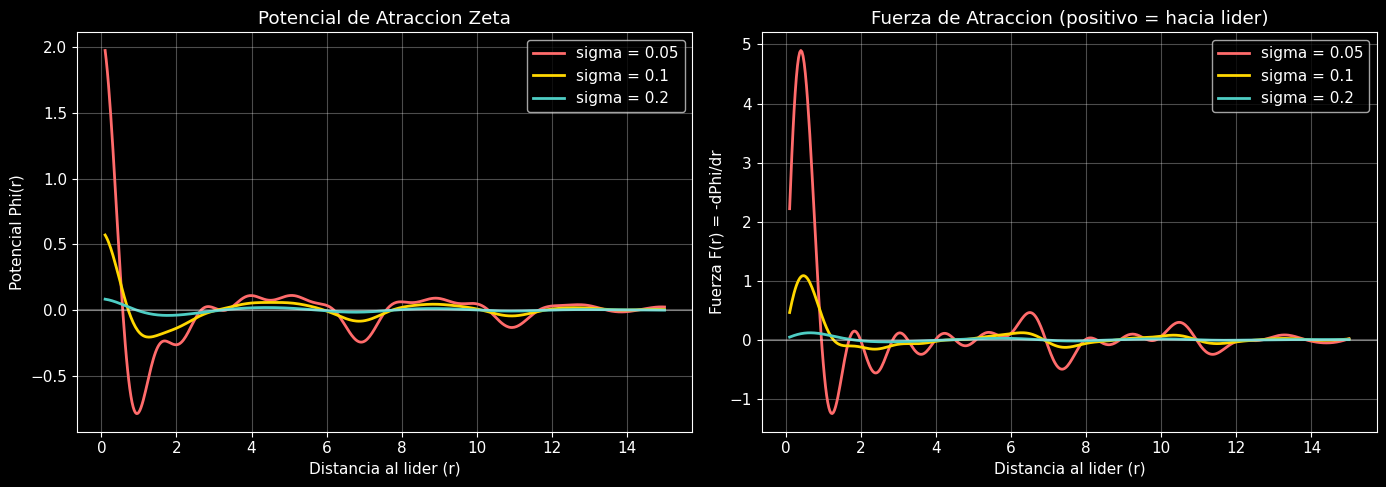

Observacion: La fuerza tiene oscilaciones debido a los zeros de Riemann.
Esto crea 'zonas de equilibrio' a distancias especificas.


In [5]:
# Visualizar potencial y fuerza
r = np.linspace(0.1, 15, 500)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Potencial
for sigma, color in [(0.05, '#FF6B6B'), (0.1, '#FFD700'), (0.2, '#4ECDC4')]:
    V = zeta_potential(r, sigma=sigma)
    ax1.plot(r, V, label=f'sigma = {sigma}', color=color, linewidth=2)

ax1.axhline(y=0, color='white', alpha=0.3)
ax1.set_xlabel('Distancia al lider (r)')
ax1.set_ylabel('Potencial Phi(r)')
ax1.set_title('Potencial de Atraccion Zeta')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Fuerza
for sigma, color in [(0.05, '#FF6B6B'), (0.1, '#FFD700'), (0.2, '#4ECDC4')]:
    F = zeta_force(r, sigma=sigma)
    ax2.plot(r, F, label=f'sigma = {sigma}', color=color, linewidth=2)

ax2.axhline(y=0, color='white', alpha=0.3)
ax2.set_xlabel('Distancia al lider (r)')
ax2.set_ylabel('Fuerza F(r) = -dPhi/dr')
ax2.set_title('Fuerza de Atraccion (positivo = hacia lider)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observacion: La fuerza tiene oscilaciones debido a los zeros de Riemann.")
print("Esto crea 'zonas de equilibrio' a distancias especificas.")

## 3. Campo de Fuerza 2D

Visualizemos el campo de fuerza generado por uno o mas lideres:

In [6]:
def compute_force_field(grid_size: int, leaders: List[Tuple[float, float]], 
                        sigma: float = 0.1) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calcula el campo de fuerza 2D generado por lideres.
    
    Returns:
        X, Y: Coordenadas del grid
        magnitude: Magnitud del campo en cada punto
    """
    x = np.linspace(0, grid_size, 50)
    y = np.linspace(0, grid_size, 50)
    X, Y = np.meshgrid(x, y)
    
    # Campo total (superposicion de todos los lideres)
    Fx = np.zeros_like(X)
    Fy = np.zeros_like(Y)
    
    for lx, ly in leaders:
        # Distancia a este lider
        dx = X - lx
        dy = Y - ly
        r = np.sqrt(dx**2 + dy**2) + 0.1  # Evitar division por cero
        
        # Magnitud de la fuerza
        F_mag = zeta_force(r, sigma=sigma)
        
        # Componentes (hacia el lider)
        Fx -= F_mag * dx / r
        Fy -= F_mag * dy / r
    
    magnitude = np.sqrt(Fx**2 + Fy**2)
    
    return X, Y, Fx, Fy, magnitude

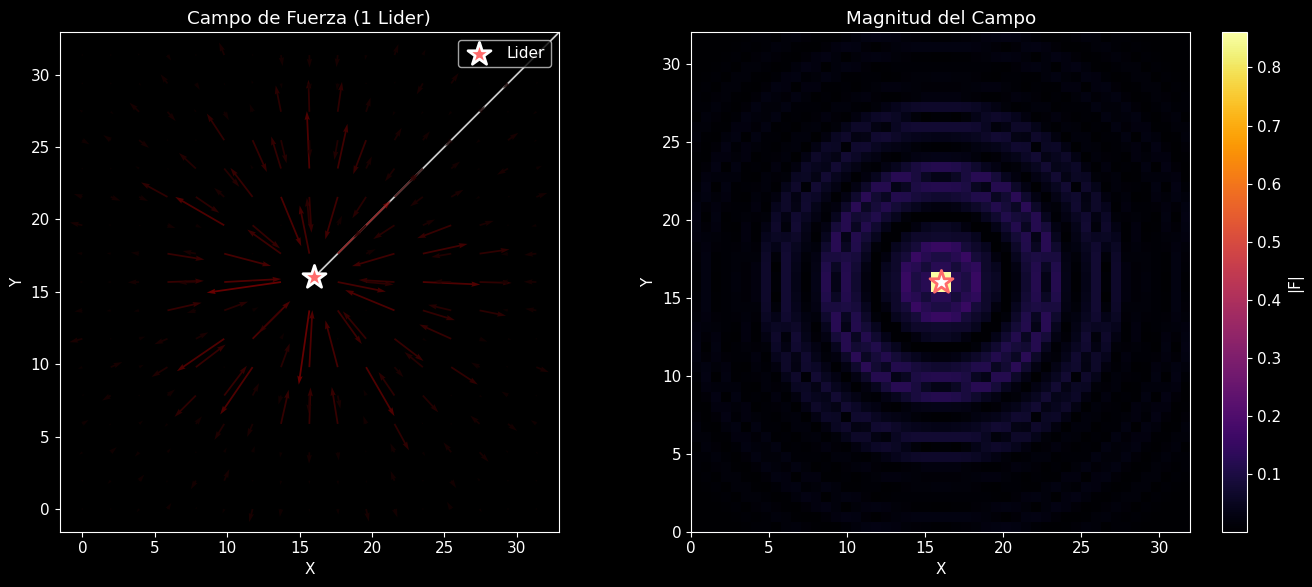

In [7]:
# Un solo lider en el centro
grid_size = 32
leaders = [(16, 16)]

X, Y, Fx, Fy, mag = compute_force_field(grid_size, leaders)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Campo vectorial
ax1.quiver(X[::3, ::3], Y[::3, ::3], Fx[::3, ::3], Fy[::3, ::3], 
           mag[::3, ::3], cmap='hot', alpha=0.8)
ax1.scatter([16], [16], c=COLORS['force'], s=300, marker='*', 
            edgecolors='white', linewidth=2, label='Lider', zorder=5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Campo de Fuerza (1 Lider)')
ax1.legend()
ax1.set_aspect('equal')

# Magnitud como heatmap
im = ax2.imshow(mag, extent=[0, grid_size, 0, grid_size], 
                origin='lower', cmap='inferno')
ax2.scatter([16], [16], c='white', s=300, marker='*', 
            edgecolors=COLORS['force'], linewidth=2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Magnitud del Campo')
plt.colorbar(im, ax=ax2, label='|F|')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

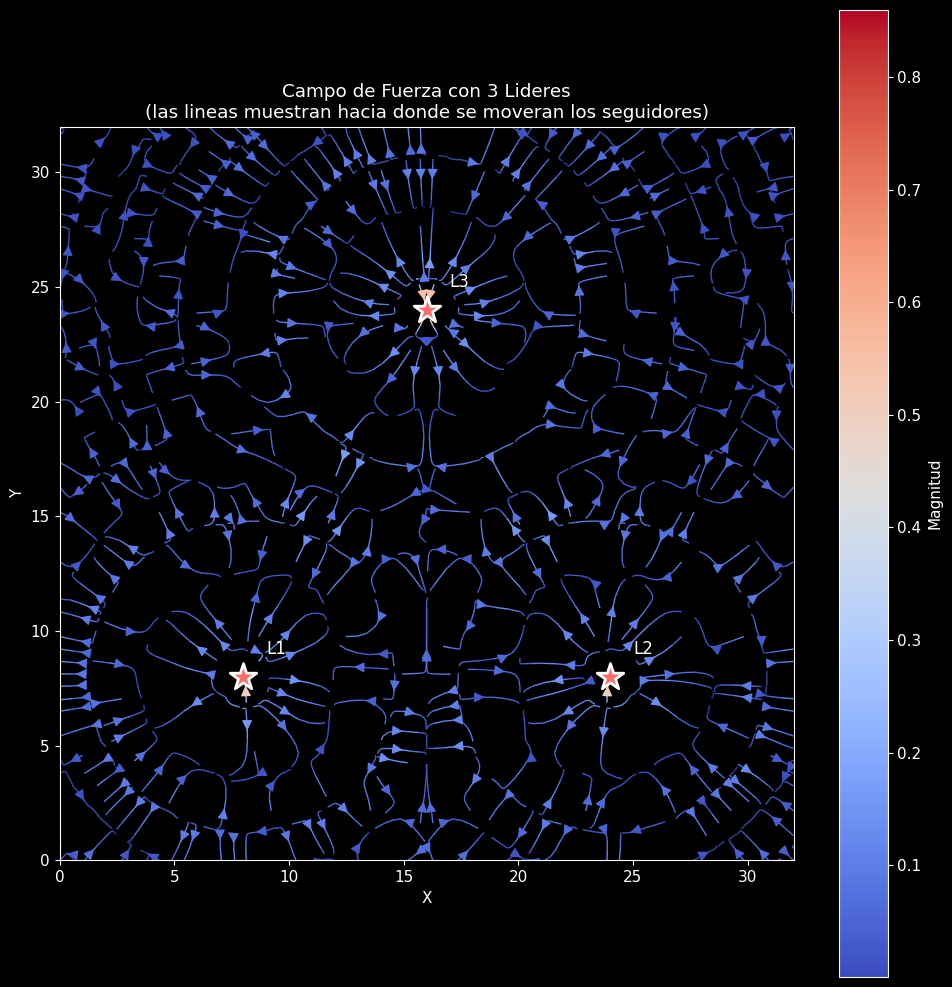

Observacion: Los seguidores se dividen entre los lideres.
Las fronteras forman una particion de Voronoi modificada por el campo zeta.


In [8]:
# Multiples lideres - competencia por seguidores
leaders_multi = [(8, 8), (24, 8), (16, 24)]

X, Y, Fx, Fy, mag = compute_force_field(grid_size, leaders_multi)

fig, ax = plt.subplots(figsize=(10, 10))

# Streamplot para ver lineas de flujo
strm = ax.streamplot(X, Y, Fx, Fy, color=mag, cmap='coolwarm', 
                     density=2, linewidth=1, arrowsize=1.5)

# Marcar lideres
for i, (lx, ly) in enumerate(leaders_multi):
    ax.scatter([lx], [ly], c=COLORS['force'], s=400, marker='*',
               edgecolors='white', linewidth=2, zorder=5)
    ax.annotate(f'L{i+1}', (lx+1, ly+1), fontsize=12, color='white')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Campo de Fuerza con 3 Lideres\n(las lineas muestran hacia donde se moveran los seguidores)')
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
plt.colorbar(strm.lines, label='Magnitud')

plt.tight_layout()
plt.show()

print("Observacion: Los seguidores se dividen entre los lideres.")
print("Las fronteras forman una particion de Voronoi modificada por el campo zeta.")

## 4. Simulacion Interactiva

Simulemos un organismo simple con dinamica Fi-Mi:

In [9]:
class SimpleOrganism:
    """Organismo simplificado para demostracion."""
    
    def __init__(self, n_cells: int = 50, grid_size: int = 32, 
                 n_leaders: int = 3, sigma: float = 0.1):
        self.grid_size = grid_size
        self.sigma = sigma
        self.cells: List[Cell] = []
        
        # Crear lideres
        for _ in range(n_leaders):
            x = np.random.uniform(5, grid_size-5)
            y = np.random.uniform(5, grid_size-5)
            self.cells.append(Cell(x, y, CellState.FORCE, energy=1.0))
        
        # Crear seguidores
        for _ in range(n_cells - n_leaders):
            x = np.random.uniform(0, grid_size)
            y = np.random.uniform(0, grid_size)
            self.cells.append(Cell(x, y, CellState.MASS, energy=np.random.uniform(0.5, 1.0)))
    
    @property
    def leaders(self) -> List[Cell]:
        return [c for c in self.cells if c.state == CellState.FORCE]
    
    @property
    def followers(self) -> List[Cell]:
        return [c for c in self.cells if c.state == CellState.MASS]
    
    def step(self, dt: float = 0.5):
        """Ejecuta un paso de simulacion."""
        leaders = self.leaders
        if not leaders:
            return
        
        for cell in self.followers:
            # Calcular fuerza total de todos los lideres
            fx, fy = 0.0, 0.0
            
            for leader in leaders:
                dx = leader.x - cell.x
                dy = leader.y - cell.y
                r = np.sqrt(dx**2 + dy**2) + 0.1
                
                # Fuerza zeta
                F = zeta_force(np.array([r]), sigma=self.sigma)[0]
                
                # Direccion hacia el lider
                fx += F * dx / r * leader.energy
                fy += F * dy / r * leader.energy
            
            # Agregar ruido
            fx += np.random.normal(0, 0.1)
            fy += np.random.normal(0, 0.1)
            
            # Actualizar posicion
            cell.x = np.clip(cell.x + fx * dt, 0, self.grid_size)
            cell.y = np.clip(cell.y + fy * dt, 0, self.grid_size)
            cell.history.append((cell.x, cell.y))
            
            # Limitar historia
            if len(cell.history) > 50:
                cell.history.pop(0)
        
        # Los lideres tambien se mueven lentamente (hacia el centro de masa)
        if self.followers:
            cx = np.mean([c.x for c in self.followers])
            cy = np.mean([c.y for c in self.followers])
            
            for leader in leaders:
                dx = cx - leader.x
                dy = cy - leader.y
                leader.x += dx * 0.01
                leader.y += dy * 0.01
    
    def plot(self, ax=None, show_trails: bool = True):
        """Visualiza el estado actual."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 10))
        
        ax.clear()
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_aspect('equal')
        ax.set_facecolor('#1a1a2e')
        
        # Dibujar trails de seguidores
        if show_trails:
            for cell in self.followers:
                if len(cell.history) > 1:
                    xs, ys = zip(*cell.history)
                    ax.plot(xs, ys, color=cell.color, alpha=0.2, linewidth=0.5)
        
        # Dibujar celulas
        for cell in self.cells:
            ax.scatter(cell.x, cell.y, c=cell.color, s=cell.size, 
                      alpha=0.8, edgecolors='white', linewidth=0.5)
        
        # Leyenda
        ax.scatter([], [], c=COLORS['force'], s=100, label=f'Lideres ({len(self.leaders)})')
        ax.scatter([], [], c=COLORS['mass'], s=60, label=f'Seguidores ({len(self.followers)})')
        ax.legend(loc='upper right')
        
        return ax

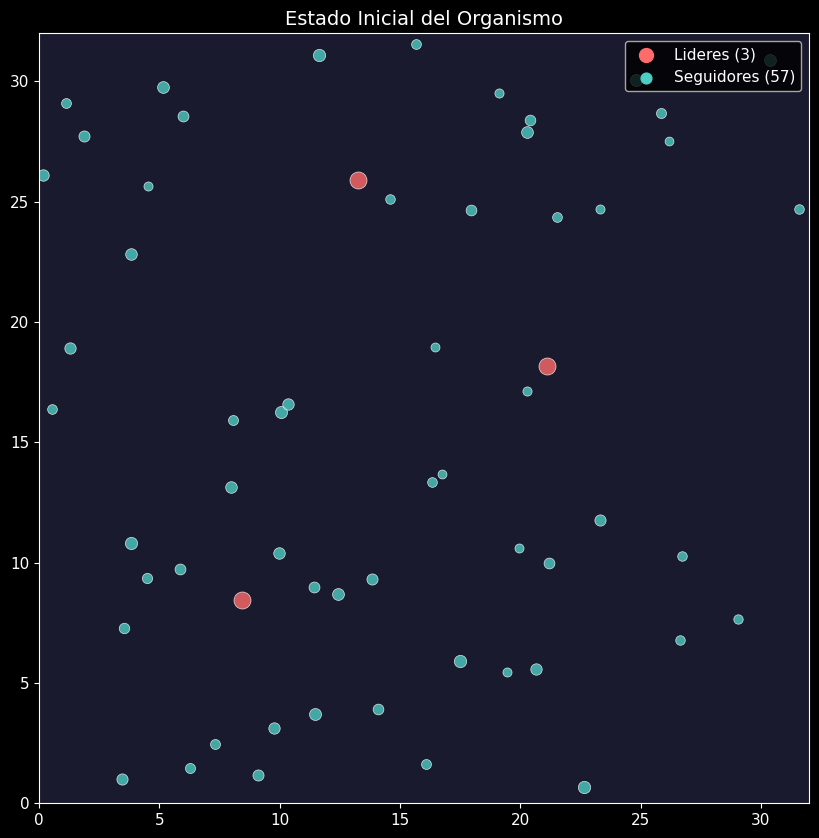

Organismo creado:
  Lideres: 3
  Seguidores: 57
  Grid: 32x32


In [10]:
# Crear y visualizar organismo inicial
np.random.seed(42)
organism = SimpleOrganism(n_cells=60, grid_size=32, n_leaders=3)

fig, ax = plt.subplots(figsize=(10, 10))
organism.plot(ax, show_trails=False)
ax.set_title('Estado Inicial del Organismo', fontsize=14)
plt.show()

print(f"Organismo creado:")
print(f"  Lideres: {len(organism.leaders)}")
print(f"  Seguidores: {len(organism.followers)}")
print(f"  Grid: {organism.grid_size}x{organism.grid_size}")

In [11]:
# Simular evolucion
np.random.seed(42)
organism = SimpleOrganism(n_cells=60, grid_size=32, n_leaders=3)

# Guardar estados para animacion
n_steps = 100
states = []

for step in range(n_steps):
    # Guardar posiciones actuales
    state = [(c.x, c.y, c.state, c.energy) for c in organism.cells]
    states.append(state)
    organism.step(dt=0.3)

print(f"Simulacion completada: {n_steps} pasos")

Simulacion completada: 100 pasos


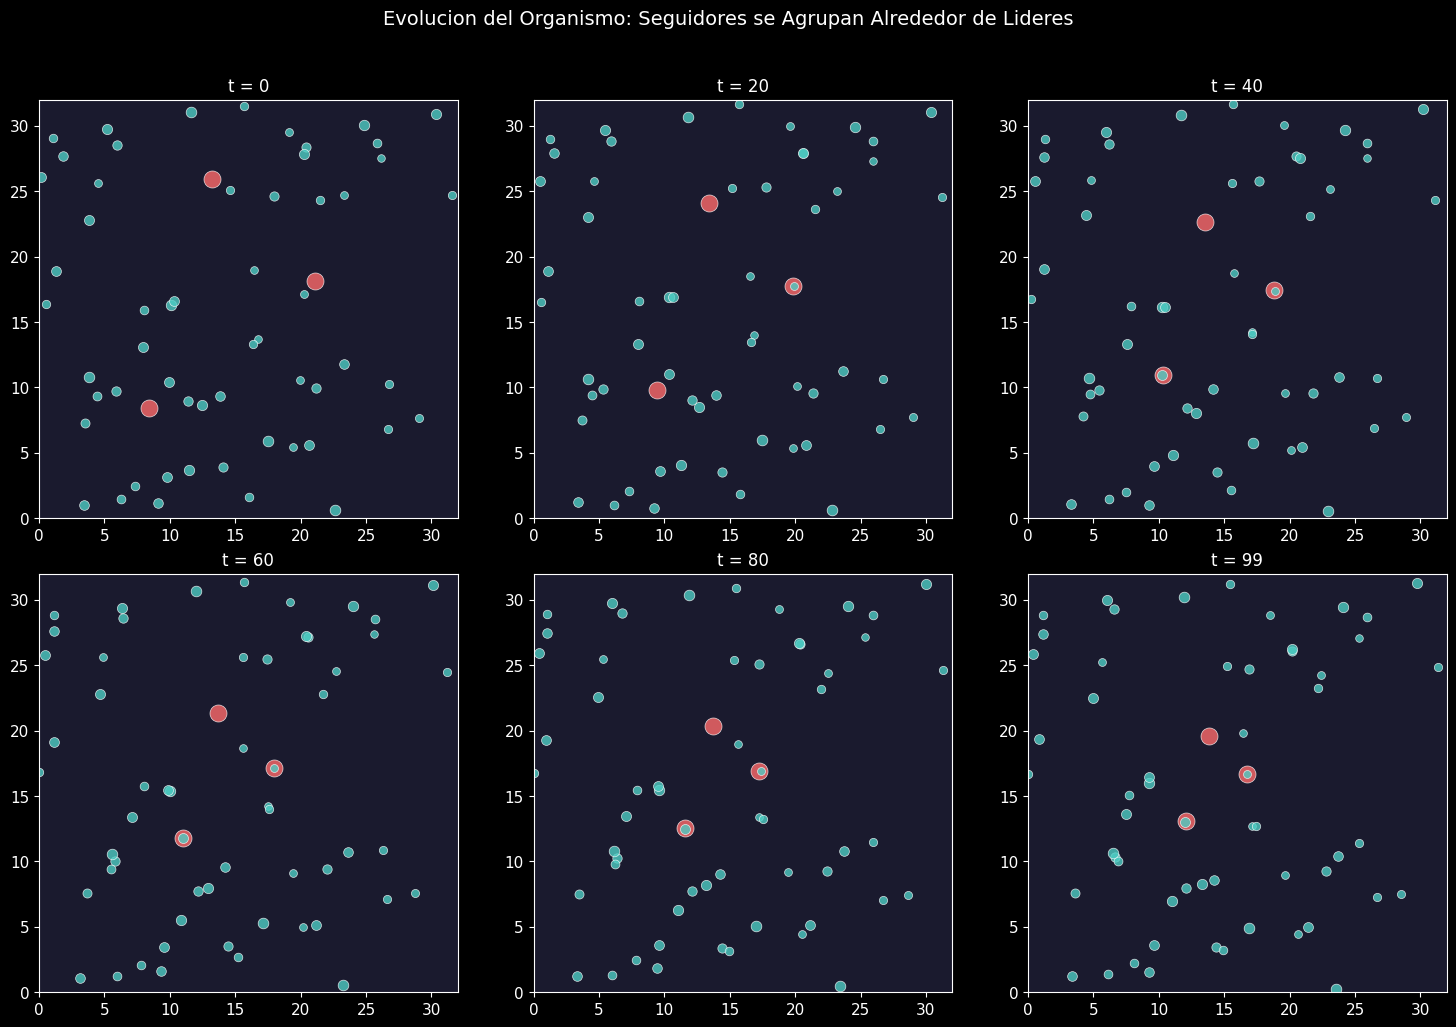

In [12]:
# Mostrar evolucion en snapshots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
snapshots = [0, 20, 40, 60, 80, 99]

for ax, t in zip(axes.flat, snapshots):
    ax.set_xlim(0, 32)
    ax.set_ylim(0, 32)
    ax.set_aspect('equal')
    ax.set_facecolor('#1a1a2e')
    
    for x, y, state, energy in states[t]:
        color = COLORS['force'] if state == CellState.FORCE else COLORS['mass']
        size = 150 if state == CellState.FORCE else 60
        ax.scatter(x, y, c=color, s=size * energy, alpha=0.8, 
                  edgecolors='white', linewidth=0.5)
    
    ax.set_title(f't = {t}', fontsize=12)

plt.suptitle('Evolucion del Organismo: Seguidores se Agrupan Alrededor de Lideres', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Propiedades Emergentes

El sistema ZetaOrganism demuestra **11+ propiedades emergentes** sin programacion explicita:

| Propiedad | Descripcion |
|-----------|-------------|
| Homeostasis | Mantiene equilibrio interno |
| Regeneracion | Se recupera de danos |
| Antifragilidad | Se fortalece bajo estres |
| Quimiotaxis | Responde a gradientes quimicos |
| Memoria espacial | Recuerda ubicaciones |
| Auto-segregacion | Tipos celulares se separan |
| Exclusion competitiva | Un lider domina |
| Particion de nicho | Lideres dividen territorio |
| Panico colectivo | Huida coordinada |
| Escape coordinado | Respuesta grupal a amenazas |
| Forrajeo colectivo | Busqueda de recursos en grupo |

In [13]:
# Demostrar REGENERACION
print("=== Demostracion: REGENERACION ===")
print("Simulando dano (eliminar 50% de celulas) y observando recuperacion...\n")

np.random.seed(123)
organism = SimpleOrganism(n_cells=80, grid_size=32, n_leaders=4)

# Simular hasta equilibrio
for _ in range(50):
    organism.step(dt=0.3)

# Medir cohesion antes del dano
def measure_cohesion(org):
    """Mide que tan agrupadas estan las celulas."""
    if len(org.followers) < 2:
        return 0
    positions = np.array([[c.x, c.y] for c in org.followers])
    center = positions.mean(axis=0)
    distances = np.sqrt(((positions - center)**2).sum(axis=1))
    return 1.0 / (1.0 + distances.mean())

cohesion_before = measure_cohesion(organism)
n_before = len(organism.cells)

# DANO: Eliminar 50% de seguidores aleatorios
followers = organism.followers
to_remove = np.random.choice(len(followers), size=len(followers)//2, replace=False)
for i in sorted(to_remove, reverse=True):
    organism.cells.remove(followers[i])

cohesion_damaged = measure_cohesion(organism)
n_damaged = len(organism.cells)

print(f"Antes del dano: {n_before} celulas, cohesion = {cohesion_before:.3f}")
print(f"Despues del dano: {n_damaged} celulas, cohesion = {cohesion_damaged:.3f}")

# Simular recuperacion (las celulas restantes se reorganizan)
cohesion_history = [cohesion_damaged]
for _ in range(100):
    organism.step(dt=0.3)
    cohesion_history.append(measure_cohesion(organism))

cohesion_after = cohesion_history[-1]
print(f"Despues de recuperacion: cohesion = {cohesion_after:.3f}")
print(f"\nRecuperacion: {(cohesion_after/cohesion_before)*100:.1f}% de cohesion original")

=== Demostracion: REGENERACION ===
Simulando dano (eliminar 50% de celulas) y observando recuperacion...



Antes del dano: 80 celulas, cohesion = 0.080
Despues del dano: 42 celulas, cohesion = 0.079


Despues de recuperacion: cohesion = 0.082

Recuperacion: 102.8% de cohesion original


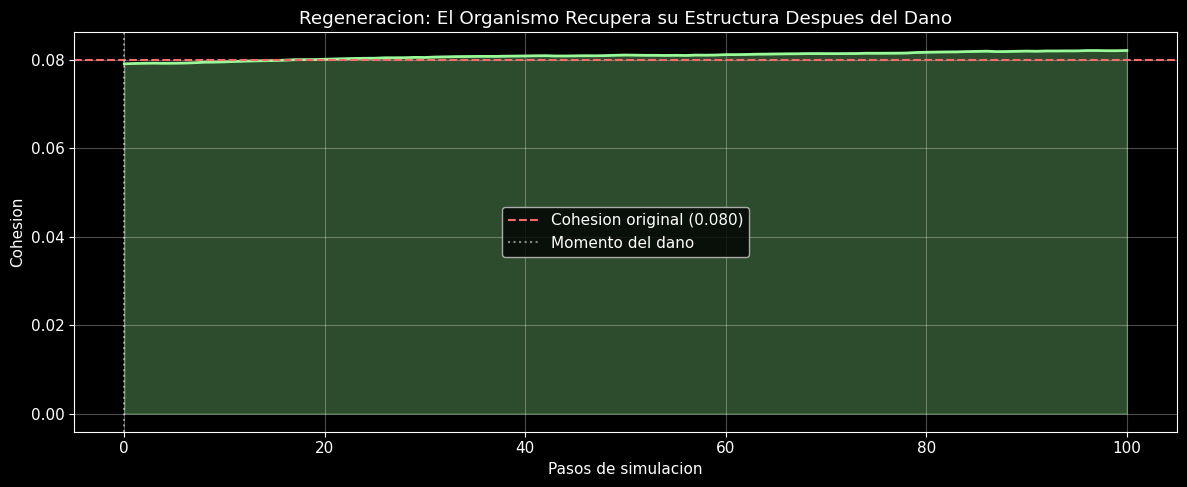

In [14]:
# Graficar recuperacion
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(cohesion_history, color=COLORS['energy'], linewidth=2)
ax.axhline(y=cohesion_before, color=COLORS['force'], linestyle='--', 
           label=f'Cohesion original ({cohesion_before:.3f})')
ax.axvline(x=0, color='white', linestyle=':', alpha=0.5, label='Momento del dano')

ax.fill_between(range(len(cohesion_history)), cohesion_history, 
                alpha=0.3, color=COLORS['energy'])

ax.set_xlabel('Pasos de simulacion')
ax.set_ylabel('Cohesion')
ax.set_title('Regeneracion: El Organismo Recupera su Estructura Despues del Dano')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Demostracion: PARTICION DE NICHO ===
Con multiples lideres, los seguidores se dividen en territorios...



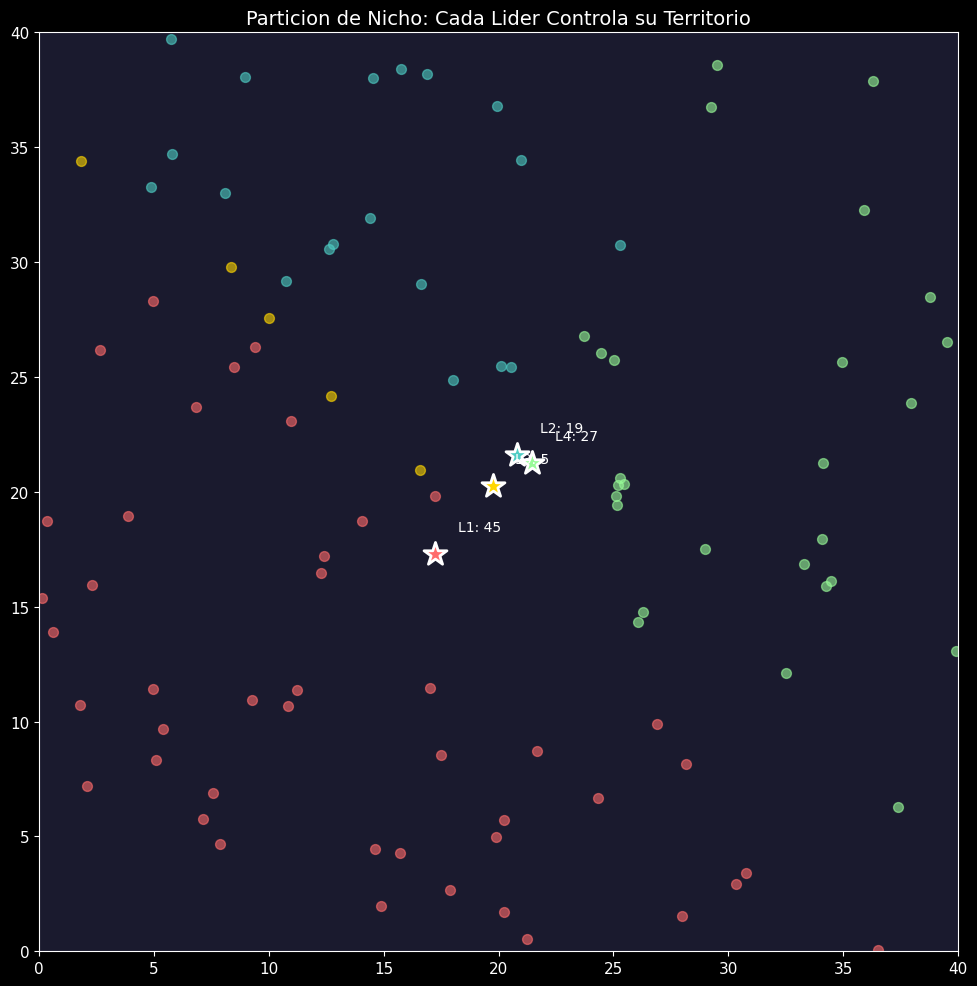

Distribucion de seguidores por lider:
  Lider 1: 45 seguidores
  Lider 2: 19 seguidores
  Lider 3: 5 seguidores
  Lider 4: 27 seguidores


In [15]:
# Demostrar PARTICION DE NICHO
print("=== Demostracion: PARTICION DE NICHO ===")
print("Con multiples lideres, los seguidores se dividen en territorios...\n")

np.random.seed(456)
organism = SimpleOrganism(n_cells=100, grid_size=40, n_leaders=4)

# Simular hasta equilibrio
for _ in range(150):
    organism.step(dt=0.3)

# Asignar cada seguidor al lider mas cercano
def assign_to_leaders(org):
    assignments = {i: [] for i in range(len(org.leaders))}
    
    for follower in org.followers:
        min_dist = float('inf')
        closest = 0
        
        for i, leader in enumerate(org.leaders):
            dist = np.sqrt((follower.x - leader.x)**2 + (follower.y - leader.y)**2)
            if dist < min_dist:
                min_dist = dist
                closest = i
        
        assignments[closest].append(follower)
    
    return assignments

assignments = assign_to_leaders(organism)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_aspect('equal')
ax.set_facecolor('#1a1a2e')

# Colores distintos para cada grupo
group_colors = ['#FF6B6B', '#4ECDC4', '#FFD700', '#98FB98']

for i, (leader, followers) in enumerate(zip(organism.leaders, assignments.values())):
    color = group_colors[i % len(group_colors)]
    
    # Seguidores
    for f in followers:
        ax.scatter(f.x, f.y, c=color, s=50, alpha=0.6)
    
    # Lider
    ax.scatter(leader.x, leader.y, c=color, s=300, marker='*',
               edgecolors='white', linewidth=2)
    ax.annotate(f'L{i+1}: {len(followers)}', (leader.x+1, leader.y+1), 
                fontsize=10, color='white')

ax.set_title('Particion de Nicho: Cada Lider Controla su Territorio', fontsize=14)
plt.tight_layout()
plt.show()

print("Distribucion de seguidores por lider:")
for i, followers in assignments.items():
    print(f"  Lider {i+1}: {len(followers)} seguidores")

## Resumen

**ZetaOrganism** demuestra que la inteligencia colectiva puede emerger de:

1. **Reglas simples**: Lideres atraen, seguidores responden
2. **Campo zeta**: Interacciones con estructura matematica profunda
3. **Dinamica local**: Cada celula solo conoce su entorno inmediato

### Propiedades Emergentes Clave

| Nivel | Propiedad | Mecanismo |
|-------|-----------|----------|
| Individual | Movimiento dirigido | Gradiente del campo |
| Grupal | Formacion de clusters | Atraccion hacia lideres |
| Organismo | Homeostasis | Retroalimentacion Fi-Mi |
| Organismo | Regeneracion | Re-organizacion espontanea |

### Conexion con Zeta

El kernel zeta aporta:
- **Oscilaciones**: Zonas de equilibrio a distancias especificas
- **Multi-escala**: Diferentes zeros capturan diferentes rangos
- **Regularidad**: Estructura no aleatoria en las interacciones

---

*"La inteligencia no se programa, se deja emerger."*